In [1]:
!pip install wfdb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.9 MB/s eta 0:00:00


In [2]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
import os
from tqdm import tqdm


# Predection

## preprocess Functions


In [3]:
from scipy.signal import butter, filtfilt
import numpy as np
def bandpass_filter(signal, fs=250, lowcut=0.5,  highcut=15.0,  order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
def smooth_signal(data, window_size=5):
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)

## Prediction Functions

In [4]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    model.eval()
    signal = signal[:len(signal) - (len(signal) % window_size)]  # crop to multiple of window_size
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != 250:
        signal = resample_signal(signal, original_fs=fs, target_fs=250)
        fs = fs
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)

    segments = []
    predictions = []

    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)

    with torch.no_grad():
        for window in segments:
            window = torch.tensor(window, dtype=torch.float32).to(device)
            output = model(window)  # (1, C, L)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (L,)
            predictions.append(pred)

    full_prediction = np.concatenate(predictions)
    return full_prediction, segments, predictions

In [5]:


def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries



In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, signal_name, model_name, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # Convert indices to time (seconds)

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}
    added_labels = set()

    # Convert zoom limits to sample indices
    zoom_start_idx = int(zoom[0] * fs)
    zoom_end_idx = int(zoom[1] * fs) if zoom[1] is not None else len(signal)

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            # Only plot if within zoom range
            if start >= zoom_start_idx and end <= zoom_end_idx:
                label = f'Predicted {wave_type}' if wave_type not in added_labels else None
                plt.fill_between(
                    time[start:end],
                    -1, 1,
                    color=wave_colors.get(wave_type, 'gray'),
                    alpha=0.3,
                    label=label
                )
                added_labels.add(wave_type)

    plt.legend(loc='upper right')
    plt.title(f"signal: {signal_name}, model: {model_name}", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Apply zoom
    plt.xlim(zoom[0], zoom[1] if zoom[1] is not None else time[-1])

    plt.show()

## Post-process Functions


In [7]:
import numpy as np

def remove_uncomplete_first_last_wave(predicted):
    start = predicted[0]
    end = predicted[-1]
    if start != 0:
      i=0
      while i < len(predicted) and predicted[i]==start:
        i+=1
      predicted[:i]=0
    if end != 0:
      i=len(predicted)-1
      while i > -1 and predicted[i]==end:
        i-=1
      predicted[i+1:]=0

    return predicted

In [8]:
import numpy as np

def merge_close_waves(predicted, max_gap=10):
  predicted = predicted.copy()
  for target_class in [1,2,3]:
    indices = np.where(predicted == target_class)[0]

    if len(indices) < 2:
        return predicted  

    for i in range(len(indices) - 1):
        current = indices[i]
        next_ = indices[i + 1]
        if 0 < next_ - current - 1 < max_gap:
            predicted[current:next_ + 1] = target_class



  return predicted

In [9]:
def remove_irrelevant_waves(predicted,start_search=2,end_search=5):
    start=0
    # Find the first P that has a QRS after it
    if 1 in predicted[:start_search*250] :
      for i in range(len(predicted)-1):
          start = i

          if predicted[i] == 1:
              start = i
              
              while i < len(predicted)-1 and predicted[i] == 1:
                i += 1
              # if it's not 0 or 2 break
              if predicted[i] == 3:
                continue
              # skip background if it exist
              if predicted[i] == 0:
                while i < len(predicted)-1 and predicted[i] == 0:
                  i += 1
              # if it's not qrs continue to next p
              if predicted[i] != 2:
                continue
              else:
                break
      predicted[:start] = 0


    # remove after last T
    if 3 in predicted[-end_search*250:]:
      
      end = predicted[-1]
      for i in range((len(predicted) - 1), -1, -1):
          end = i

          if predicted[i] == 3:
              end = i
              while i > 0 and predicted[i] == 3:
                i -= 1
              # if it's not 0 or 2 break
              if predicted[i] == 1:
                continue
              # skip background if it exist
              if predicted[i] == 0:
                while i > 0 and predicted[i] == 0:
                  i -= 1
              # if it's not qrs continue to next t
              if predicted[i] != 2:
                continue
              else:
                break
      predicted[end+1:] = 0

    return (predicted)



In [10]:
def check_repeated_waves(predicted):
    cleaned = predicted.copy()
    for target_class in [1,2,3]:
      segments = []
      in_segment = False
      start = 0

      # Step 1: Collect all segments of the target class
      for i, val in enumerate(predicted):
          if val == target_class and not in_segment:
              in_segment = True
              start = i
          elif val != target_class and in_segment:
              in_segment = False
              segments.append((start, i - 1))
      if in_segment:
          segments.append((start, len(predicted) - 1))

      # Step 2: Check for pairs of segments with only background (0) in between
      i = 0
      while i < len(segments) - 1:
          s1, e1 = segments[i]
          s2, e2 = segments[i + 1]
          between = cleaned[e1 + 1:s2]

          if np.all(between == 0):  # Only background between them
              len1 = e1 - s1 + 1
              len2 = e2 - s2 + 1

              # Remove the shorter one
              if len1 < len2:
                  cleaned[s1:e1 + 1] = 0
              else:
                  cleaned[s2:e2 + 1] = 0

              # Remove the deleted segment from the list
              segments.pop(i if len1 < len2 else i + 1)
          else:
              i += 1


    return cleaned


In [11]:
from scipy.signal import find_peaks
from tqdm import tqdm
def fix_before_P(signal,mask,p_start,p_end,slope_threshold=0.02):
  diff_signal = np.diff([signal[p_start],signal[p_start-5]])  # check around the Q point for slope change
  j = 0
  while True:
    while np.abs(diff_signal[-1]) >= slope_threshold and signal[p_start]>signal[p_start-1] and mask[p_start-1]==0:  # Continue until slope becomes small
        j+=1
        p_start -= 1
        mask[p_start] = 1  # mark as part of the QRS
        diff_signal = np.diff([signal[p_start],signal[p_start-5]])  # re-evaluate slope
    if mask[p_start-1]!=0:
      break
    if j == 0:

        slope_threshold -= 0.001
        #print("slope_threshold: ",slope_threshold)
        if slope_threshold < 0.005:
          break
    else:
        break
  #print ("fixed_before with peak:",j)
  return mask,p_start


def fix_P(signal, mask):
    p_mask = (mask == 1).astype(int)
    qrs_mask = (mask == 2).astype(int)

    transitions = np.diff(p_mask, prepend=0)
    p_starts = np.where(transitions == 1)[0]

    qrs_starts = np.where(np.diff(qrs_mask, prepend=0) == 1)[0]

    fixed_p_info = []

    for i in tqdm(range(len(p_starts)), desc="Processing P"):

        slope_threshold = 0.02  # arbitrary threshold for slope to be considered small
        p_start = p_starts[i]

        p_next = p_starts[i+1] if i < len(p_starts) - 1 else len(mask)
        p_indices = np.where((mask == 1) & (np.arange(len(mask)) >= p_start) & (np.arange(len(mask)) < p_next))[0]

        p_end = p_indices[-1] if  len(p_indices)>0 else p_start
        #print("p_start,p_end: ",p_start,p_end)
        # Get indices of current P segment
        if len(p_indices) < 3:
            continue

        p_wave = signal[p_indices]

        # Check for peak inside current P segment
        peaks, _ = find_peaks(p_wave, prominence=0.01)
        has_peak = len(peaks) > 0
        peak_index = p_indices[peaks[0]] if has_peak else None

        # If no peak, look after end of P segment
        post_p_peak_index = None
        if has_peak:
          #print("has peak")
          mask, p_start = fix_before_P(signal, mask,p_start,p_end)
          j=0
          #print(p_end)
          while (p_end + 1 < len(signal)) and signal[p_end] > signal[p_start] and mask[p_end + 1] == 0:
            j += 1
            p_end += 1
            mask[p_end] = 1
        if not has_peak:

            # Look ahead to the next QRS start
            next_qrs_start = qrs_starts[qrs_starts > p_end]
            next_qrs_start = next_qrs_start[0] if len(next_qrs_start) > 0 else len(signal)

            # Look AFTER the P segment
            post_range = np.arange(p_start,min(len(signal) ,p_end + 50,  next_qrs_start ))
            post_peaks = []
            if len(post_range) > 3:
                post_wave = signal[post_range]
                peaks, _ = find_peaks(post_wave, prominence=0.01)
                # Filter by mask == 0
                for p in peaks:
                    peak_idx = post_range[p]
                    # Check that the region from p_end to peak_idx is all mask == 0
                    if np.all(mask[p_end+1:peak_idx + 1] == 0):
                        post_peaks.append(peak_idx)


            # Look BEFORE the P segment
            pre_range = np.arange(max(0, p_start - 50), p_end)  # limit the look-back window to ~400ms
            pre_peaks = []
            if len(pre_range) > 3:
                pre_wave = signal[pre_range]
                peaks, _ = find_peaks(pre_wave, prominence=0.01)
                # Filter by mask == 0
                pre_peaks = [pre_range[p] for p in peaks if mask[pre_range[p]] == 0]
                for p in peaks:
                    peak_idx = pre_range[p]
                    # Check that the region from p_end to peak_idx is all mask == 0
                    if np.all(mask[peak_idx + 1:p_start] == 0):
                        pre_peaks.append(peak_idx)

            # Closest peak
            ## Combine both and choose closest properly
            closest_peak = None
            min_distance = float('inf')

            ## Compare post-peaks to p_end
            for peak in post_peaks:
                dist = abs(peak - p_end)
                if dist < min_distance:
                    min_distance = dist
                    closest_peak = peak

            ## Compare pre-peaks to p_start
            for peak in pre_peaks:
                dist = abs(peak - p_start)
                if dist < min_distance:
                    min_distance = dist
                    closest_peak = peak

            post_p_peak_index = closest_peak if closest_peak is not None else None

            peak = None
            if post_p_peak_index is not None:
              if post_p_peak_index < p_start:
                peak = "before"
              else:
                peak = "after"


            #print(peak)
            if peak == "after":
                mask, p_start = fix_before_P(signal, mask,p_start,p_end)
                j=0
                while (p_end + 1 < len(signal)) and signal[p_end] > signal[p_start] and mask[p_end + 1] == 0:
                  j += 1
                  p_end += 1
                  mask[p_end] = 1
            elif peak == "before":

                mask[post_p_peak_index-2:p_start] = 1
                p_start = post_p_peak_index-2
                mask, p_start = fix_before_P(signal, mask,p_start,p_end)


        fixed_p_info.append({
            'start': p_indices[0],
            'end': p_indices[-1],
            'has_peak': has_peak,
            'peak_index': peak_index,
            'post_p_peak_index': post_p_peak_index
        })
        #print (fixed_p_info)

    return mask

In [12]:


def fix_QRS(signal, mask, fs=250):
    features_list = []
    time = np.arange(len(signal)) / fs

    # Find all QRS starts
    qrs_mask = (mask == 2).astype(int)
    transitions = np.diff(qrs_mask, prepend=0)
    qrs_starts = np.where(transitions == 1)[0]
    fixed_down = []
    fixed_up = []
    fixed_start = []

    slope_threshold = 0.02  # arbitrary threshold for slope to be considered small
    #print(len(qrs_starts))

    for i in range(len( qrs_starts)):
        #print("starting:",i,"/",len( qrs_starts))
        #print("fixing qrs ",i)
        qrs_start = qrs_starts[i]
        next_qrs_start = qrs_starts[i+1] if i < len(qrs_starts) - 1 else len(mask)
        qrs_indices = np.where((mask == 2) & (np.arange(len(mask)) >= qrs_start) & (np.arange(len(mask)) < next_qrs_start))[0]
        qrs_end = qrs_indices[-1]
        j = 0

        # QRS Begining

        ## Searching for p
        p_indices = np.where(mask[:qrs_start] == 1)[0]
        valid_p = []
        for p_end in reversed(p_indices):
            if np.all(mask[p_end:qrs_start] != 2) and np.all(mask[p_end:qrs_start] != 3):
                p_start = p_end
                while p_start > 0 and mask[p_start - 1] == 1:
                    p_start -= 1
                valid_p = list(range(p_start, p_end + 1))
                break
        p_wave = signal[valid_p] if valid_p else np.array([])
        p_indices = valid_p if valid_p else np.array([])
        dist = qrs_start - p_indices[-1] if len(p_indices) > 0 else float('inf')
        #  if p
        if len(p_wave)>0 and dist < 20:
          mask[p_indices[-1]+1:qrs_start] = 2
          qrs_start = p_indices[-1]+1
        else:

          # Look BEFORE the QRS segment
          pre_range = np.arange(max(0, qrs_start - 100), qrs_start)  # limit to ~400ms before
          pre_peaks = []
          if len(pre_range) > 3:
              pre_wave = signal[pre_range]
              peaks, _ = find_peaks(pre_wave, prominence=0.01)
              pre_peaks = [pre_range[p] for p in peaks if mask[pre_range[p]] == 0]

          # Track first peak (if any)
          first_peak_before_qrs = pre_peaks[0] if pre_peaks else None

          # Begin slope-based backtracking
          j = 0
          while True:
              # Stop if slope is small
              if qrs_start - 3 < 0: break
              diff_signal = np.diff([signal[qrs_start], signal[qrs_start - 3]])

              if np.abs(diff_signal[-1]) < slope_threshold:
                  break

              # Stop if we hit the first peak
              if first_peak_before_qrs is not None and qrs_start <= first_peak_before_qrs:
                  break

              # Otherwise, continue extending the QRS
              if mask[qrs_start - 1] != 0:
                  break

              j += 1
              qrs_start -= 1
              mask[qrs_start] = 2  # extend QRS

              # Optional: decrease threshold if no progress
              if j == 0:

                  slope_threshold -= 0.001
                  if slope_threshold<0: break


        fixed_start.append(j)
        # QRS ending

        ## Before Q
        while signal[qrs_end] >= signal[qrs_end+1] and mask[qrs_end+1]==0:

            j+=1
            qrs_end += 1
            mask[qrs_end] = 2

        fixed_down.append(j)

        ## After Q
        diff_signal = np.diff([signal[qrs_end],signal[qrs_end+5]])  # check around the Q point for slope change
        j = 0
        while True:
          while np.abs(diff_signal[-1]) >= slope_threshold and mask[qrs_end+1]==0:  # Continue until slope becomes small
              j+=1
              qrs_end += 1
              mask[qrs_end] = 2  # mark as part of the QRS
              diff_signal = np.diff([signal[qrs_end],signal[qrs_end+5]])  # re-evaluate slope
          if mask[qrs_end+1]!=0:
            break
          if j == 0:
              slope_threshold -= 0.001
              if slope_threshold<0.005: break
          else:
              break

          #print ("j: ",j)
        fixed_up.append(j)


    #print ("fixed_down:",fixed_down)
    #print ("fixed_up:",fixed_up)
    #print ("slope_threshold: ",slope_threshold)
    return mask



In [13]:
def fast_fix_QRS(signal, mask, fs=250):
    # time = np.arange(len(signal)) / fs
    # indices = np.arange(len(mask))  # Precompute indices array

    # Precompute slopes for QRS start and end adjustments
    # slope_start = np.zeros_like(signal)
    # slope_start[3:] = signal[3:] - signal[:-3]  # slope[i] = signal[i] - signal[i-3]
    slope_end = np.zeros_like(signal)
    slope_end[:-5] = signal[:-5] - signal[5:]    # slope[i] = signal[i] - signal[i+5]

    # Identify QRS regions (mask == 2)
    qrs_mask = (mask == 2).astype(np.int8)
    transitions = np.diff(qrs_mask, prepend=0)
    qrs_starts = np.flatnonzero(transitions == 1)
    qrs_ends = np.flatnonzero(transitions == -1) - 1
    n = len(signal)

    if len(qrs_ends) < len(qrs_starts):
        qrs_ends = np.append(qrs_ends, n - 1)

    for i in tqdm(range(len(qrs_starts)), desc="Processing QRS"):
        qrs_start = qrs_starts[i]
        # next_qrs_start = qrs_starts[i+1] if i < len(qrs_starts)-1 else len(mask)
        # Find QRS end within the current segment
        qrs_end = qrs_ends[i]
        #before_qrs_end = qrs_ends[i-1] if i > 0 else 0
        # Adjust QRS start based on preceding P wave
        p_indices = np.where(mask[max(0, qrs_start-200):qrs_start] == 1)[0]
        valid_p = []
        if len(p_indices) > 0:
            # Check from the end backwards
            p_end = p_indices[-1]
            p_end = p_indices[-1]  # just take the last one
            if not np.any(mask[p_end:qrs_start] >= 2):  # no QRS or T in between
                p_start = p_end
                if p_start > 0 and mask[p_start-1] == 1:
                    p_start -= 1
                valid_p = np.arange(p_start, p_end + 1)
                
        if len(valid_p) > 0 and (qrs_start - valid_p[-1]) < 20:
            # print("vaid p, qrs moved back:",qrs_start-p_end)
            mask[p_end+1:qrs_start] = 2
            qrs_start = p_end +1
        else:
            # Precompute signal range before QRS
            # print("no vaid p")
            
            pre_start = max(0, qrs_start - 100)
            pre_wave = signal[pre_start:qrs_start]
            
            # Find first valid peak before QRS
            first_peak_before_qrs = None
            if len(pre_wave) > 3:
                peaks, _ = find_peaks(pre_wave, prominence=0.01)
                for p in peaks:
                    if mask[pre_start + p] == 0:
                        # print("found peak before qrs")
                        first_peak_before_qrs = pre_start + p
                        break
            # Track first peak (if any)

                    
            original_qrs_start = qrs_start  # save original position
            slope_threshold = 0.02
            max_back_steps = 25
            back_steps = 0
        
            while back_steps < max_back_steps and qrs_start >= 3:
                       
                diff_signal = signal[qrs_start] - signal[qrs_start - 3]
                if abs(diff_signal) < slope_threshold:
                    
                    # Dynamic threshold (only if stuck)
                    if back_steps == 0 and slope_threshold>0.005:
                        slope_threshold = max(slope_threshold - 0.001, 0.005)
                        continue 
                    break
        
                if first_peak_before_qrs is not None and qrs_start <= first_peak_before_qrs:
                    break
        
                if mask[qrs_start - 1] != 0:
                    break
        
                # Move QRS start backward
                qrs_start -= 1
                back_steps += 1
        
            
            mask[qrs_start:original_qrs_start] = 2
            # print("vaid p, qrs moved back:",original_qrs_start-qrs_start)
            
        # Adjust QRS end
        # Extend until signal stops descending
        original_qrs_end = qrs_end
        while qrs_end < len(signal)-1 and mask[qrs_end+1] == 0 and signal[qrs_end] >= signal[qrs_end+1]:
            qrs_end += 1
        
        # Vectorize the mask update to do it all at once
        mask[original_qrs_end:qrs_end+1] = 2

        # Further adjust based on slope
        slope_threshold_end = 0.02
        max_forward_steps = 25
        forward_steps = 0
        # print("vaid p, qrs moved back:",original_qrs_start-qrs_start)
        
        
        while True:
            while (qrs_end < len(signal)-5 
                   and forward_steps < max_forward_steps 
                   and abs(slope_end[qrs_end]) >= slope_threshold_end 
                   and mask[qrs_end+1] == 0):
                qrs_end += 1
                forward_steps += 1
            if abs(slope_end[qrs_end]) < slope_threshold_end and forward_steps == 0 and slope_threshold_end>0.005: 
                slope_threshold_end = max(slope_threshold_end - 0.001, 0.005)
                continue
            else :
                mask[qrs_end - forward_steps + 1: qrs_end + 1] = 2
                break
                                
            
        
    return mask

In [14]:
def post_process_ecg(predicted):

    predicted = remove_uncomplete_first_last_wave(predicted)
    predicted = merge_close_waves(predicted)
    predicted = remove_irrelevant_waves(predicted)
    predicted = check_repeated_waves(predicted)

    return predicted

predicted = np.array([1,1,0, 1, 1, 0,0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2, 0, 3, 3, 0,0,0,0,0,0,3, 3, 3, 0,0,0,1, 1, 0, 0, 2, 2, 0, 3, 3,0,3,3])
predicted = post_process_ecg(predicted)
print(predicted)

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 2 0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 1 1 0
 0 2 2 0 3 3 0 0 0]


## Load model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                              padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv1d(F_int, 1, kernel_size=1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNet1D_Enhanced(nn.Module):
    def __init__(self, in_channels=1, n_classes=4, base_filters=64):
        super().__init__()

        # Encoder with residual blocks and multi-scale context
        self.enc1 = ResidualConvBlock1D(in_channels, base_filters)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = ResidualConvBlock1D(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = ResidualConvBlock1D(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool1d(2)

        self.enc4 = ResidualConvBlock1D(base_filters*4, base_filters*8)
        self.pool4 = nn.MaxPool1d(2)

        # Bottleneck with dilated convolution
        self.bottleneck = nn.Sequential(
            ResidualConvBlock1D(base_filters*8, base_filters*16, dilation=2),
            ResidualConvBlock1D(base_filters*16, base_filters*16, dilation=4)
        )

        # Decoder with attention gates
        self.upconv4 = nn.ConvTranspose1d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(base_filters*8, base_filters*8, base_filters//2)
        self.dec4 = ResidualConvBlock1D(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose1d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(base_filters*4, base_filters*4, base_filters//4)
        self.dec3 = ResidualConvBlock1D(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose1d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(base_filters*2, base_filters*2, base_filters//8)
        self.dec2 = ResidualConvBlock1D(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose1d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters//16)
        self.dec1 = ResidualConvBlock1D(base_filters*2, base_filters)

        # Output with multi-scale feature fusion
        self.final_conv = nn.Sequential(
            nn.Conv1d(base_filters, base_filters//2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base_filters//2),
            nn.ReLU(),
            nn.Conv1d(base_filters//2, n_classes, kernel_size=1)
        )

        # Boundary refinement
        self.boundary_refine = nn.Conv1d(n_classes, n_classes, kernel_size=5, padding=2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with attention
        d4 = self.upconv4(b)
        e4 = self.att4(d4, center_crop(e4, d4.shape[-1]))
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, center_crop(e3, d3.shape[-1]))
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, center_crop(e2, d2.shape[-1]))
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, center_crop(e1, d1.shape[-1]))
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        # Output
        out = self.final_conv(d1)

        # Boundary refinement
        out = out + self.boundary_refine(out)  # Residual connection

        return out


def center_crop(enc_feat, target_size):
    _, _, L = enc_feat.size()
    diff = L - target_size
    if diff == 0:
        return enc_feat
    elif diff < 0:
        raise ValueError("Encoder feature shorter than target")
    start = diff // 2
    end = start + target_size
    return enc_feat[:, :, start:end]

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model_deep = UNet1D_Enhanced(n_classes=4).to(device)
model_deep.load_state_dict(torch.load("/kaggle/input/unet-model-for-ecg-mask-detection/pytorch/default/1/updated_unet1d_ecg_qrs.pth", map_location=device))
model_deep.to(device)
model_deep.eval()

/tmp/ipykernel_13/2491763897.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deep.load_state_dict(torch.load("/kaggle/input/unet-model-for-ecg-mask-detection/pytor

UNet1D_Enhanced(
  (enc1): ResidualConvBlock1D(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ResidualConvBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

# Features extraction

In [17]:
import numpy as np
from scipy.stats import skew, kurtosis, entropy
import tensorflow as tf

R_model = tf.keras.models.load_model("/kaggle/input/r-detection/tensorflow2/default/2/R_detection.h5")

# Preprocess qrs_wave the same way as during training
def preprocess_qrs_wave(wave, target_length=250):
    wave = wave.astype(np.float32)
    # Normalize
    wave = (wave - np.mean(wave)) / (np.std(wave) + 1e-8)
    # Pad or truncate to target length
    if len(wave) < target_length:
        wave = np.pad(wave, (0, target_length - len(wave)), mode='constant')
    else:
        wave = wave[:target_length]
    return wave.reshape(1, -1, 1)

def extract_features_per_qrs(signal ,mask,annotations, fs=250):
    features_list = []
    #time = np.arange(len(signal)) / fs
    n = len(signal)

    # Find all QRS starts
    
    qrs_mask = (mask == 2).astype(np.int8)
    transitions = np.diff(qrs_mask, prepend=0)
    qrs_starts = np.flatnonzero(transitions == 1)
    qrs_ends = np.flatnonzero(transitions == -1) - 1

    if len(qrs_ends) < len(qrs_starts):
        qrs_ends = np.append(qrs_ends, n - 1)
    
    previous_r_index = None  # To calculate RR interval

    # Turn your annotations into NumPy arrays once
    samples = np.array([s for s, _ in annotations])
    symbols = np.array([sym for _, sym in annotations])    
    def get_annotations_in_range(start, end):
        mask = (samples >= start) & (samples <= end)
        return list(zip(samples[mask], symbols[mask]))
        
    for i in tqdm(range(len(qrs_starts)), desc="extract features"):
        

        p_wave = np.array([])
        qrs_wave = np.array([])
        t_wave = np.array([])
        p_indices = np.array([])
        t_indices = np.array([])


        qrs_start = qrs_starts[i]
        # Find QRS end within the current segment
        qrs_end = qrs_ends[i]
        next_qrs_start = qrs_starts[i+1] if i < len(qrs_starts) - 1 else len(mask)

        # Get current QRS region
        #if len(mask[qrs_start:qrs_end+1]) != len(np.arange(qrs_start, qrs_end + 1)):
        #    continue

        qrs_indices = np.arange(qrs_start, qrs_end + 1)[mask[qrs_start:qrs_end+1] == 2]
        #print("qrs_indices:",qrs_indices)
        if len(qrs_indices) <= 1:
            continue
        #print("qrs_start,end:",qrs_start,qrs_end)isnt

        # Search for the P wave just before this QRS (no QRS or T in between)
        start_idx = qrs_ends[i-1]-1 if i > 0 else 0
        p_indices = np.where(mask[start_idx:qrs_start] == 1)[0]+start_idx
        #p_indices = np.where(mask[:qrs_start] == 1)[0]
        valid_p = []
        for p_end in reversed(p_indices):
                if np.all(mask[p_end:qrs_start] != 2) and np.all(mask[p_end:qrs_start] != 3):
                    p_start = p_end
                    while p_start > 0 and mask[p_start - 1] == 1:
                        p_start -= 1
                    valid_p = list(range(p_start, p_end + 1))
                    break

        #print("p start,end:",valid_p[0],valid_p[-1])

        #
        # Search for the T wave just after this QRS (no QRS or P in between)

        t_indices = np.where(mask[qrs_end:next_qrs_start] == 3)[0]
        t_indices = t_indices + (qrs_end )
        #print("t_indices:",t_indices)

        valid_t = []
        for t_start_offset in t_indices:
            t_start = t_start_offset
            #print("mask[qrs_end:t_start]:",mask[qrs_end:t_start])
            if np.all(mask[qrs_end+1:t_start] != 2) and np.all(mask[qrs_end+1:t_start] != 1):
                #print("got t")
                t_end = t_start
                while t_end < len(mask) - 1 and mask[t_end + 1] == 3:
                    t_end += 1
                valid_t = list(range(t_start, t_end + 1))
                break
        # Extract samples
        valid_p = [i for i in valid_p if i < len(signal)]
        p_wave = signal[valid_p] if valid_p else np.array([])
        
        qrs_indices = [i for i in qrs_indices if i < len(signal)]
        if len(qrs_indices) <= 1:
            continue
        
        qrs_indices = np.array(qrs_indices)
        
        #print(type(qrs_indices[0]))
        qrs_wave = signal[qrs_indices]
        valid_t = [i for i in valid_t if i < len(signal)]
        t_wave = signal[valid_t] if valid_t else np.array([])
        p_indices = valid_p if valid_p else np.array([])
        t_indices = valid_t if valid_t else np.array([])
        
        f = {}
        padding = 0
        
        if len(p_wave)>0:
          f['start'] = p_indices[0]-padding if p_indices[0] > padding else 0
          
        else :
          f['start'] = qrs_indices[0]-padding if qrs_indices[0] > padding else 0

        if len(t_wave)>0:
          f['end'] = t_indices[-1]+padding if t_indices[-1] < len(signal)-padding else len(signal)
          
        else :
          f['end'] = qrs_indices[-1]+padding if qrs_indices[-1] < len(signal)-padding else len(signal)


        p_start,p_end,t_start,t_end = None,None,None,None
        if len(p_wave)>0:
            p_start = p_indices[0]
            p_end = p_indices[-1]
        if len(t_wave)>0:
            t_start = t_indices[0]
            t_end = t_indices[-1]
        f['qrs_start'] = qrs_indices[0]
        f['qrs_end'] =  qrs_indices[-1]
        f['p_start'] = p_start
        f['p_end'] =  p_end
        f['t_start'] = t_start
        f['t_end'] =  t_end
        


        f['Duree_P_ms'] = len(p_wave) / fs * 1000 if len(p_wave) > 0 else 0
        f['Duree_QRS_ms'] = len(qrs_wave) / fs * 1000 if len(qrs_wave) > 0 else 0
        f['Duree_T_ms'] = len(t_wave) / fs * 1000 if len(t_wave) > 0 else 0

        f['Intervalle_PR_ms'] = ((qrs_start - valid_p[0]) / fs * 1000) if valid_p else 0
        f['Intervalle_QT_ms'] = ((valid_t[-1] - qrs_start) / fs * 1000) if valid_t else 0
        f['Intervalle_ST_ms'] = ((valid_t[0] - qrs_end) / fs * 1000) if valid_t else 0


        # Amplitude_P
        if len(p_wave) > 0:
          default_start = (p_wave[0]+p_wave[-1])/2 if len(p_wave) > 0 else 0
          #print(default_start)
          p_index = p_indices[np.argmax(np.abs(signal[p_indices]-default_start))]
          p_amplitude = signal[p_index]
          f['P_index']= p_index
          f['Amplitude_P'] = p_amplitude
        else:
          f['P_index']= 0
          f['Amplitude_P'] = 0

        
        all_wave = signal[int(f['start']):int(f['end'])]
        all_indices = range(int(f['start']),int(f['end']))
        R_window_input = preprocess_qrs_wave(all_wave)
        prediction = R_model.predict(R_window_input,verbose=0)[0]  # shape: (250,)
        # Find predicted R-peak
        predicted_r_relative = np.argmax(prediction)
       
        if (predicted_r_relative>len(range(all_indices[0],qrs_indices[-1]))):
            r_index = qrs_indices[-1]
        else:
            predicted_r_relative = min(predicted_r_relative,len(all_indices)-1)
            r_index = all_indices[predicted_r_relative]
        
        r_amplitude = signal[r_index]

        f['R_index']= r_index# Preprocess qrs_wave the same way as during training


        f['Amplitude_R'] = r_amplitude
        # RR interval
        if previous_r_index is not None:
            f['Intervalle_RR_ms'] = (r_index - previous_r_index) / fs * 1000
        else:
            f['Intervalle_RR_ms'] = np.nan   # Or np.nan if you prefer

        # Update previous_r_index for next beat
        previous_r_index = r_index

        # --- Detect Q and S waves relative to R ---
        q_index, s_index = None, None
        q_amplitude, s_amplitude = None, None

        if r_amplitude > np.median(signal[qrs_indices]):  # R is a max peak
            q_candidates = qrs_indices[qrs_indices < r_index]
            s_candidates = qrs_indices[qrs_indices > r_index]
            if len(q_candidates) > 0:
                q_index = q_candidates[np.argmin(signal[q_candidates])]
                q_amplitude = signal[q_index]
            if len(s_candidates) > 0:
                s_index = s_candidates[np.argmin(signal[s_candidates])]
                s_amplitude = signal[s_index]
        else:  # R is a min peak
            q_candidates = qrs_indices[qrs_indices < r_index]
            s_candidates = qrs_indices[qrs_indices > r_index]
            if len(q_candidates) > 0:
                q_index = q_candidates[np.argmax(signal[q_candidates])]
                q_amplitude = signal[q_index]
            if len(s_candidates) > 0:
                s_index = s_candidates[np.argmax(signal[s_candidates])]
                s_amplitude = signal[s_index]

        # Add Q and S info
        f['Q_index'] = q_index if q_index is not None else 0
        f['Amplitude_Q'] = q_amplitude if q_amplitude is not None else 0
        f['S_index'] = s_index if s_index is not None else 0
        f['Amplitude_S'] = s_amplitude if s_amplitude is not None else 0


        # Amplitude_T
        if len(t_wave) > 0:
          default_start = (t_wave[0]+t_wave[-1])/2 if len(t_wave) > 0 else 0
          # print(default_start)
          t_index = t_indices[np.argmax(np.abs(signal[t_indices]-default_start))]
          t_amplitude = signal[t_index]
          f['T_index']= t_index
          f['Amplitude_T'] = t_amplitude
        else:
          f['T_index']= 0
          f['Amplitude_T'] = 0

        # Amplitude Ratio
        f['T/R_ratio'] = np.max(np.abs(t_wave)) / np.max(np.abs(qrs_wave)) if len(t_wave) > 0 and len(qrs_wave) > 0 else 0
        f['P/R_ratio'] = np.max(np.abs(p_wave)) / np.max(np.abs(qrs_wave)) if len(p_wave) > 0 and len(qrs_wave) > 0 else 0


        # Pente (slopes)
        f['QRS_area'] = np.trapz(np.abs(qrs_wave), dx=1/fs)

        # QR Slope
        if q_index is not None and q_index < r_index:
            delta_qr = (r_amplitude - q_amplitude)
            time_qr = (r_index - q_index) / fs
            f['Slope_QR'] = delta_qr / time_qr if time_qr != 0 else 0
        else:
            f['Slope_QR'] = 0

        # RS Slope
        if s_index is not None and r_index < s_index:
            delta_rs = (s_amplitude - r_amplitude)
            time_rs = (s_index - r_index) / fs
            f['Slope_RS'] = delta_rs / time_rs if time_rs != 0 else 0
        else:
            f['Slope_RS'] = 0

        # --- P wave symmetry ---
        if len(p_wave) > 2:
            mid = len(p_wave) // 2
            left = p_wave[:mid]
            right = p_wave[mid:]
            f['P_symmetry'] = 1 - abs(np.mean(left) - np.mean(right)) / (np.mean(left) + 1e-6)
        else:
            f['P_symmetry'] = 0

        # --- T wave inversion ---
        if len(t_wave) > 0:
            f['T_inversion'] = int(np.sign(f['Amplitude_T']) != np.sign(f['Amplitude_R']))
        else:
            f['T_inversion'] = -1

        # --- QRS axis estimate ---
        axis_indicator = (abs(f['Amplitude_R']) - abs(f['Amplitude_S']) + abs(f['Amplitude_Q'])) / (
            abs(f['Amplitude_R']) + abs(f['Amplitude_S']) + abs(f['Amplitude_Q']) + 1e-6)

        f['QRS_axis_estimate'] = axis_indicator

        # Heart rate
        if pd.notna(f['Intervalle_RR_ms']) and f['Intervalle_RR_ms'] > 0:
            f['Heart_rate_bpm'] = 60000 / f['Intervalle_RR_ms']
        else:
            f['Heart_rate_bpm'] = np.nan  # or 0 if your pipeline prefers

        # Premature beat detection (basic heuristic)
        recent_rrs = [
            beat['Intervalle_RR_ms'] 
            for beat in features_list[-3:] 
            if pd.notna(beat['Intervalle_RR_ms']) and beat['Intervalle_RR_ms'] > 0
        ]

        if len(recent_rrs) >= 2:
            mean_rr = np.mean(recent_rrs)
            f['Premature_beat'] = int(f['Intervalle_RR_ms'] < 0.8 * mean_rr)
        else:
            f['Premature_beat'] = 0



        #  Rhythm Features

        # Local rhythm variability (SDNN)
        f['Local_RR_variability'] = np.std(recent_rrs) if len(recent_rrs) > 1 else 0

        # RMSSD (local)
        if len(recent_rrs) > 2:
            diffs = np.diff(recent_rrs)
            f['Local_RMSSD'] = np.sqrt(np.mean(diffs**2))
        else:
            f['Local_RMSSD'] = 0

        # Bigeminy / Trigeminy pattern
        all_rrs = [
            beat['Intervalle_RR_ms']
            for beat in features_list[-5:]
            if pd.notna(beat['Intervalle_RR_ms']) and beat['Intervalle_RR_ms'] > 0
        ]
        if len(all_rrs) >= 4:
            pattern = (np.array(all_rrs) < 0.9 * np.mean(all_rrs)).astype(int)
            pattern_str = ''.join(map(str, pattern))
            f['Bigeminy'] = int('10' in pattern_str)
            f['Trigeminy'] = int('110' in pattern_str)
        else:
            f['Bigeminy'] = 0
            f['Trigeminy'] = 0
        Type = get_annotations_in_range(qrs_start,qrs_end)
        #if len(p_wave) > 0 and len(t_wave) > 0 and Type is not None:
        if Type is not None and len(Type)>0:
            
          f['type'] = str(Type[0][1])
          f['R_reel'] = int(Type[0][0])
                
            
        else:
          f['type'] = None
          f['R_reel'] = None

        features_list.append(f)

    return features_list



2025-05-26 20:21:43.403614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748290903.669668      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748290903.746795      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 20:22:00.949734: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## display functions

In [18]:
def plot_beat_with_features(signal, mask, beat_features, fs, window_start=0):
    import matplotlib.pyplot as plt
    import numpy as np

    time = np.arange(len(signal)) / fs

    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, color='black', label='ECG Signal', alpha=0.8)

    # Mask indices
    p_indices = np.where(mask == 1)[0]
    qrs_indices = np.where(mask == 2)[0]
    t_indices = np.where(mask == 3)[0]

    # --- Highlight P wave
    if len(p_indices) > 0:
        plt.plot(time[p_indices], signal[p_indices], color='blue', label='P Wave', linewidth=2, alpha=0.6)

    # --- Highlight QRS
    if len(qrs_indices) > 0:
        plt.plot(time[qrs_indices], signal[qrs_indices], color='red', label='QRS Complex', linewidth=2, alpha=0.6)

    # --- Highlight T wave
    if len(t_indices) > 0:
        plt.plot(time[t_indices], signal[t_indices], color='green', label='T Wave', linewidth=2, alpha=0.6)

    # --- Duration bars
    if len(p_indices) > 0:
        plt.axvspan(time[p_indices[0]], time[p_indices[-1]], color='blue', alpha=0.1, label='Durée P')
    if len(qrs_indices) > 0:
        plt.axvspan(time[qrs_indices[0]], time[qrs_indices[-1]], color='red', alpha=0.1, label='Durée QRS')
    if len(t_indices) > 0:
        plt.axvspan(time[t_indices[0]], time[t_indices[-1]], color='green', alpha=0.1, label='Durée T')

    # --- P and R peak markers
    print("beat_features: ", beat_features)
    if 'P_index' in beat_features and beat_features['P_index'] is not None :
        p_idx = int(beat_features['P_index']) - window_start
        if 0 <= p_idx < len(signal):
            plt.plot(time[p_idx], signal[p_idx], 'bo', label='P Peak')
            plt.annotate(f'P Peak\n{signal[p_idx]:.2f}', (time[p_idx], signal[p_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

    if 'R_index' in beat_features and beat_features['R_index'] is not None :
        r_idx = int(beat_features['R_index']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'ro', label='R Peak')
            plt.annotate(f'R Peak\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    if 'R_reel' in beat_features and beat_features['R_reel'] is not None:
        r_idx = int(beat_features['R_reel']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'yo', label='R Reel')
            plt.annotate(f'R Reel\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='yellow')
    if 'Q_index' in beat_features and beat_features['Q_index'] is not None:
        q_idx = int(beat_features['Q_index']) - window_start
        if 0 <= q_idx < len(signal):
            plt.plot(time[q_idx], signal[q_idx], 'mo', label='Q Peak')
            plt.annotate(f'Q Peak\n{signal[q_idx]:.2f}', (time[q_idx], signal[q_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='magenta')

    if 'S_index' in beat_features and beat_features['S_index'] is not None:
        s_idx = int(beat_features['S_index']) - window_start
        if 0 <= s_idx < len(signal):
            plt.plot(time[s_idx], signal[s_idx], 'co', label='S Peak')
            plt.annotate(f'S Peak\n{signal[s_idx]:.2f}', (time[s_idx], signal[s_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='cyan')


    if 'T_index' in beat_features and beat_features['T_index'] is not None:
        t_idx = int(beat_features['T_index']) - window_start
        if 0 <= t_idx < len(signal):
            plt.plot(time[t_idx], signal[t_idx], 'go', label='T Peak')
            plt.annotate(f'T Peak\n{signal[t_idx]:.2f}', (time[t_idx], signal[t_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='green')


    # --- Interval lines (flat)
    y_level = min(signal) - 0.2  # slightly below signal
    if len(p_indices) > 0 and len(qrs_indices) > 0:
      plt.hlines(y_level, time[p_indices[0]], time[qrs_indices[0]], colors='purple', linestyles='--', label='Intervalle PR')
    if len(qrs_indices) > 0 and len(t_indices) > 0:
        plt.hlines(y_level - 0.2, time[qrs_indices[0]], time[t_indices[-1]], colors='orange', linestyles=':', label='Intervalle QT')
        plt.hlines(y_level - 0.4, time[qrs_indices[-1]], time[t_indices[0]], colors='green', linestyles='-.', label='Intervalle ST')

        # --- Final Touch
    plt.title("Visualisation d'un battement ECG avec caractéristiques")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()

    # Enforce min y-range of 5
    ymin = min(signal)
    ymax = max(signal)
    if ymax - ymin < 10:
        midpoint = (ymin + ymax) / 2
        plt.ylim(midpoint - 5, midpoint + 5)

    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_ecg_with_rr(signal, r_indices, fs=250):
    time = np.arange(len(signal)) / fs
    r_indices = np.array(r_indices)

    # Define time limits for zoom
    start_time = r_indices[0] / fs
    end_time = r_indices[-1] / fs

    # Plot ECG signal
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, label='ECG Signal', color='black')

    # Mark R peaks
    r_times = r_indices / fs
    r_amps = signal[r_indices]
    plt.plot(r_times, r_amps, 'ro', label='R Peaks')

    # RR interval lines and labels
    for i in range(1, len(r_indices)):
        t1, t2 = r_times[i - 1], r_times[i]
        y = max(r_amps[i - 1], r_amps[i]) + 0.2
        plt.plot([t1, t2], [y, y], color='blue', linestyle='--', linewidth=1)
        mid_t = (t1 + t2) / 2
        rr_ms = (t2 - t1) * 1000
        plt.text(mid_t, y + 0.05, f"{rr_ms:.0f} ms", ha='center', fontsize=8, color='blue')

    # Set x-limits to first and last R peak
    plt.xlim(start_time, end_time)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.title("ECG Signal (From First to Last Beat) with R Peaks and RR Intervals")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_heart_rate(signal, r_indices, fs=250, duration=5):
    import matplotlib.pyplot as plt
    import numpy as np

    # Calculate RR intervals in seconds
    rr_intervals = np.diff(r_indices) / fs
    heart_rate = 60 / rr_intervals  # Heart rate in bpm (beats per minute)

    # Calculate time for heart rate plot
    rr_times = (np.array(r_indices[1:]) / fs)

    # Plot Heart Rate
    plt.figure(figsize=(15, 5))
    plt.plot(rr_times, heart_rate, label='Heart Rate (bpm)', color='purple')
    plt.xlabel('Time (s)')
    plt.ylabel('Heart Rate (bpm)')
    plt.title('Heart Rate Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_qrs_duration(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    qrs_durations = []

    for features in beat_features_list:
        if 'Q_index' in features and 'S_index' in features:
            q_idx = int(features['Q_index'])
            s_idx = int(features['S_index'])
            qrs_duration = (s_idx - q_idx) / fs  # Duration in seconds
            qrs_durations.append(qrs_duration)

    # Plot QRS durations
    plt.figure(figsize=(15, 5))
    plt.plot(qrs_durations, label='QRS Duration (s)', color='orange', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('QRS Duration (s)')
    plt.title('QRS Duration for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_pr_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    pr_intervals = []

    for features in beat_features_list:
        if 'P_index' in features and 'Q_index' in features:
            p_idx = int(features['P_index'])
            q_idx = int(features['Q_index'])
            pr_interval = (q_idx - p_idx) / fs  # Interval in seconds
            pr_intervals.append(pr_interval)

    # Plot PR intervals
    plt.figure(figsize=(15, 5))
    plt.plot(pr_intervals, label='PR Interval (s)', color='blue', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('PR Interval (s)')
    plt.title('PR Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_qt_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    qt_intervals = []

    for features in beat_features_list:
        if 'Q_index' in features and 'T_index' in features:
            q_idx = int(features['Q_index'])
            t_idx = int(features['T_index'])
            qt_interval = (t_idx - q_idx) / fs  # Interval in seconds
            qt_intervals.append(qt_interval)

    # Plot QT intervals
    plt.figure(figsize=(15, 5))
    plt.plot(qt_intervals, label='QT Interval (s)', color='green', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('QT Interval (s)')
    plt.title('QT Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_st_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    st_intervals = []

    for features in beat_features_list:
        if 'S_index' in features and 'T_index' in features:
            s_idx = int(features['S_index'])
            t_idx = int(features['T_index'])
            st_interval = (t_idx - s_idx) / fs  # Interval in seconds
            st_intervals.append(st_interval)

    # Plot ST intervals
    plt.figure(figsize=(15, 5))
    plt.plot(st_intervals, label='ST Interval (s)', color='red', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('ST Interval (s)')
    plt.title('ST Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# test mask

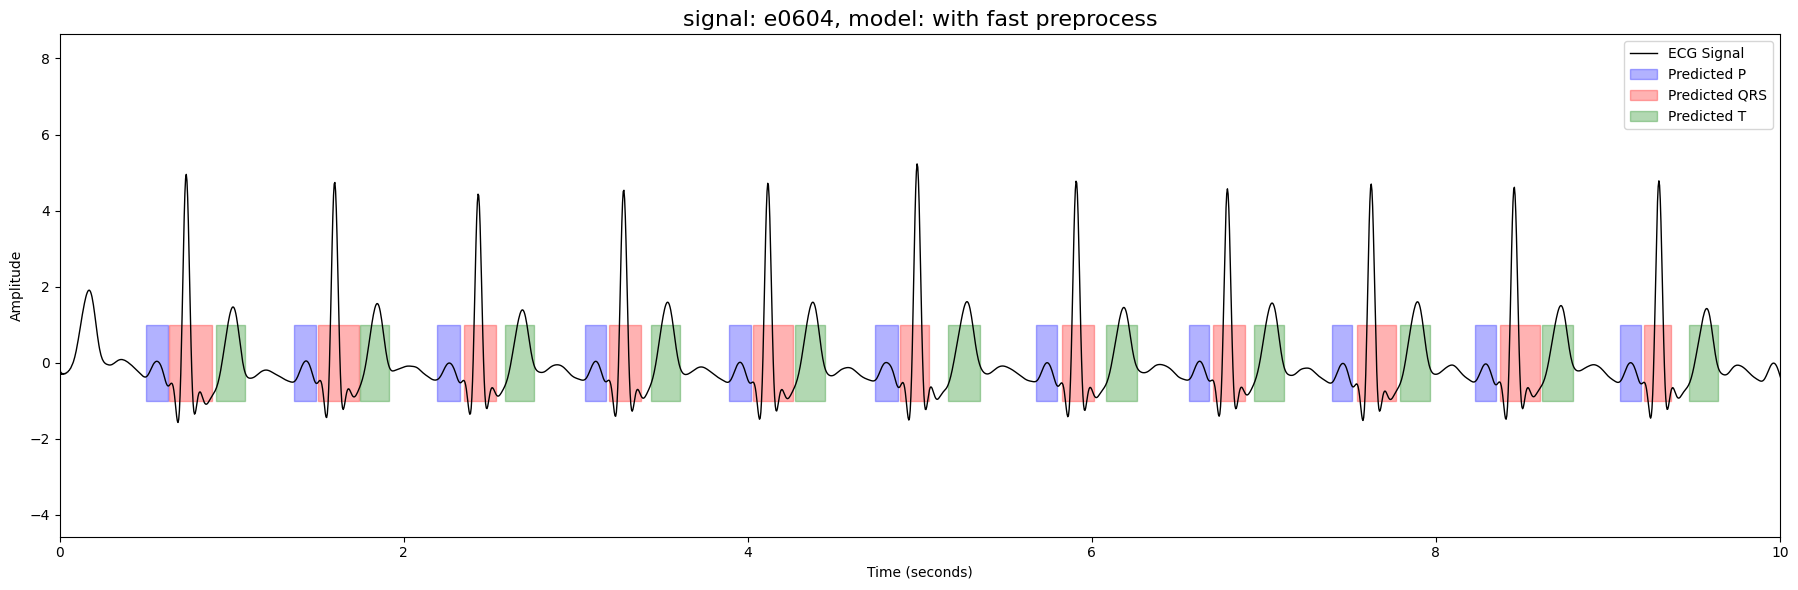

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


In [19]:
def div_signal(signal, window_size = 240):
    segments = []
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
            window = signal[:, :, i:i+window_size]
            segments.append(window)
    signal = np.concatenate(segments, axis=2)
    signal = signal.reshape(-1)
    return signal
#record = wfdb.rdrecord(edb_path+'e0604')# Run prediction
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/'
rd_name = '103'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
signal = div_signal(signal)

if fs != 250:
    signal = resample_signal(signal, original_fs=fs, target_fs=250)
    fs = fs
mask = np.loadtxt('/kaggle/input/arr-mitdb-mask-detection/masks/'+rd_name+'_mask.csv', delimiter=",", dtype=int)

boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with fast preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")



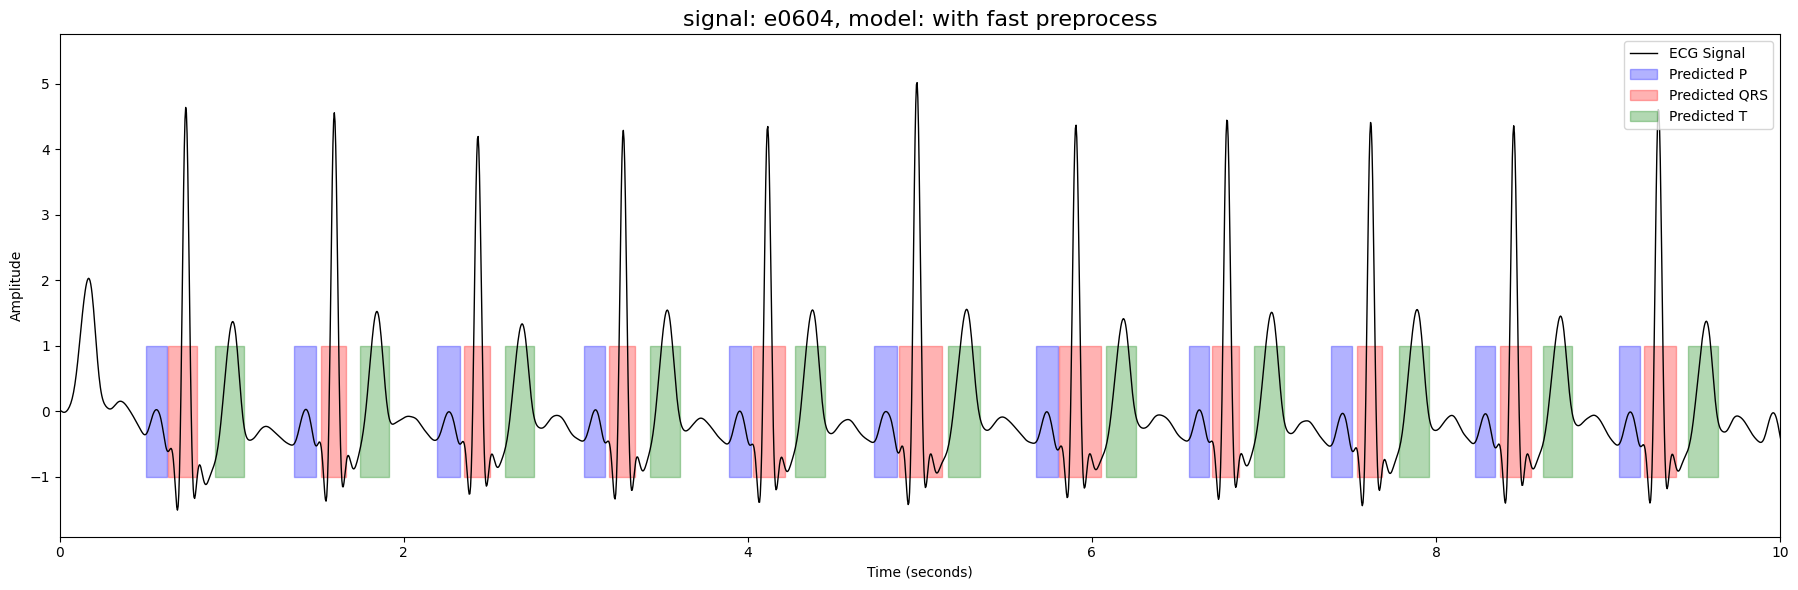

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


In [20]:
def div_signal(signal, window_size = 240):
    segments = []
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
            window = signal[:, :, i:i+window_size]
            segments.append(window)
    signal = np.concatenate(segments, axis=2)
    signal = signal.reshape(-1)
    return signal
#record = wfdb.rdrecord(edb_path+'e0604')# Run prediction
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/qtdb/1.0.0/'
rd_name = 'sel103'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
signal = div_signal(signal)

if fs != 250:
    signal = resample_signal(signal, original_fs=fs, target_fs=250)
    fs = fs
mask = np.loadtxt('/kaggle/input/arr-mitdb-mask-detection/masks/'+rd_name+'_mask.csv', delimiter=",", dtype=int)

boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with fast preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")



# detection


# making dataset


In [21]:
import numpy as np
import pandas as pd
import wfdb
import random
import contextlib
import sys

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr
            
def extract_features_from_mask(record_name, path, mask_path, target_fs=250):
    
    record = wfdb.rdrecord(path)
    signal = record.p_signal[:, 0]
    fs = record.fs
    try:
        annotation = wfdb.rdann(path, 'atr')
    except Exception as e:
        print(f"'atr' annotation not found for {path}, trying 'pu'...")
        try:
            annotation = wfdb.rdann(path, 'pu')
        except Exception as e2:
            print(f"No valid annotation found for {record_name}: {e2}")
            annotation = None  # or skip this record / raise if needed


    
    end = len(signal)/fs
    start = 0
    annotations = []
    for i in range(len(annotation.sample)):
      sample = annotation.sample[i]
      symbol = annotation.symbol[i]
      if sample >= start*fs and sample <= end*fs:
        annotations.append((sample, symbol))
      elif sample > end*fs:
        break
    
    adjusted_annotations = [
        (adjust_annotations(sample, fs, 250)-(250*start), symbol)
        for sample, symbol in annotations
    ]
    
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    signal = div_signal(signal)
    
    if fs != 250:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
        fs = target_fs
    try:
        mask = np.loadtxt(mask_path, delimiter=",", dtype=int)
        # print("found mask:",record_name)
    except:
        print("mask not found:",record_name)
        return pd.DataFrame([])
    boundaries = get_wave_boundaries(mask)
    all_predicted_masks = mask.reshape(1, -1)
    

    features_per_beat = extract_features_per_qrs(signal, all_predicted_masks.flatten(),adjusted_annotations, fs)

    df = pd.DataFrame(features_per_beat)
    if df.empty:
        return df

    df = df[['R_index'] + [col for col in df.columns if col != 'R_index']]
    df = pd.DataFrame(features_per_beat)
    df['record_name'] = record_name
    df['beat_number'] = range(1, len(df) + 1)

    main_cols = ['record_name', 'beat_number', 'type', 'R_index']
    df = df[main_cols + [col for col in df.columns if col not in main_cols]]
    print('end')
    
    return df



In [22]:
import os
import wfdb
import pandas as pd
import contextlib
from functools import partial
import sys


@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Patch tqdm globally if needed
silent_tqdm = partial(tqdm, disable=True)




def batch_features(mitdb_path, mit_records, target_fs=250, save_csv=False, output_csv="all_features.csv"):
    
    all_dfs = []
    #print('mit_records,',mit_records)
    #for record_name in tqdm(mit_records, total=len(mit_records), desc="Processing mit_records"):
    #for record_name in tqdm(mit_records, total=len(mit_records), desc="Processing mit_records"):
    for record_name in tqdm( mit_records, total=len(mit_records), desc="features extraction"):
        full_path = os.path.join(mitdb_path, record_name)
        with suppress_output():
            df = extract_features_from_mask(record_name, full_path, '/kaggle/input/arr-mitdb-mask-detection/masks/'+record_name+'_mask.csv', target_fs=250)   
            
        all_dfs.append(df)

    combined_df = pd.concat(all_dfs, ignore_index=True)

    if save_csv:
        combined_df.to_csv(output_csv, index=False)
        print(f"Saved combined features to {output_csv}")

    return combined_df



In [23]:
#mit_records = ['123']
import os
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  # Ensure no duplicates


mitdb_path = "/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/"
qtdb_path = "/kaggle/input/qtdb-ludb/physionet.org/files/qtdb/1.0.0"
mit_records = get_all_records(mitdb_path)
qtdb_records = get_all_records(qtdb_path)

print(f"Found {len(mit_records)},{len(qtdb_records)} records.")
print(f"List{mit_records}")
mit_records.sort()
qtdb_records.sort()
print(mit_records)
print(qtdb_records)


Found 48,105 records.
List['205', '101', '222', '217', '234', '230', '122', '201', '102', '119', '207', '203', '219', '100', '210', '223', '231', '213', '123', '106', '232', '104', '215', '208', '112', '118', '108', '233', '116', '105', '200', '220', '113', '115', '111', '209', '214', '124', '228', '107', '114', '221', '117', '212', '103', '109', '202', '121']
['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
['sel100', 'sel102', 'sel103', 'sel104', 'sel114', 'sel116', 'sel117', 'sel123', 'sel14046', 'sel14157', 'sel14172', 'sel15814', 'sel16265', 'sel16272', 'sel16273', 'sel16420', 'sel16483', 'sel16539', 'sel16773', 'sel16786', 'sel16795', 'sel17152', 'sel17453', 'sel213', 'sel221', 'sel223', 'sel230',

In [24]:
# 123 fast
df_all1 = batch_features(mitdb_path, mit_records, save_csv=True,output_csv="arr-mitdb-beat-features.csv") 
df_all2 = batch_features(qtdb_path, qtdb_records, save_csv=True,output_csv="qtdb-beat-features.csv") 
# 1789/2655
    # /kaggle/input/qtdb-ludb/physionet.org/files/qtdb/1.0.0/sel30.atr

features extraction: 100%|██████████| 48/48 [2:57:38<00:00, 222.05s/it]


Saved combined features to arr-mitdb-beat-features.csv


features extraction: 100%|██████████| 105/105 [2:42:14<00:00, 92.71s/it] 


Saved combined features to qtdb-beat-features.csv


# check features

In [25]:
import matplotlib.pyplot as plt
import numpy as np
def plot_beat_with_features(signal, mask, beat_features, fs, window_start=0):

    time = np.arange(len(signal)) / fs

    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, color='black', label='ECG Signal', alpha=0.8)

    # Mask indices
    p_indices = np.where(mask == 1)[0]
    qrs_indices = np.where(mask == 2)[0]
    t_indices = np.where(mask == 3)[0]

    # --- Highlight P wave
    if len(p_indices) > 0:
        plt.plot(time[p_indices], signal[p_indices], color='blue', label='P Wave', linewidth=2, alpha=0.6)

    # --- Highlight QRS
    if len(qrs_indices) > 0:
        plt.plot(time[qrs_indices], signal[qrs_indices], color='red', label='QRS Complex', linewidth=2, alpha=0.6)

    # --- Highlight T wave
    if len(t_indices) > 0:
        plt.plot(time[t_indices], signal[t_indices], color='green', label='T Wave', linewidth=2, alpha=0.6)

    # --- Duration bars
    if len(p_indices) > 0:
        plt.axvspan(time[p_indices[0]], time[p_indices[-1]], color='blue', alpha=0.1, label='Durée P')
    if len(qrs_indices) > 0:
        plt.axvspan(time[qrs_indices[0]], time[qrs_indices[-1]], color='red', alpha=0.1, label='Durée QRS')
    if len(t_indices) > 0:
        plt.axvspan(time[t_indices[0]], time[t_indices[-1]], color='green', alpha=0.1, label='Durée T')

    # --- P and R peak markers
    print("beat_features: ", beat_features)
    if 'P_index' in beat_features and beat_features['P_index'] is not None :
        p_idx = int(beat_features['P_index']) - window_start
        if 0 <= p_idx < len(signal):
            plt.plot(time[p_idx], signal[p_idx], 'bo', label='P Peak')
            plt.annotate(f'P Peak\n{signal[p_idx]:.2f}', (time[p_idx], signal[p_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

    if 'R_index' in beat_features and beat_features['R_index'] is not None :
        r_idx = int(beat_features['R_index']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'ro', label='R Peak')
            plt.annotate(f'R Peak\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    if 'R_reel' in beat_features and beat_features['R_reel'] is not None:
        r_idx = int(beat_features['R_reel']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'yo', label='R Reel')
            plt.annotate(f'R Reel\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='yellow')
    if 'Q_index' in beat_features and beat_features['Q_index'] is not None:
        q_idx = int(beat_features['Q_index']) - window_start
        if 0 <= q_idx < len(signal):
            plt.plot(time[q_idx], signal[q_idx], 'mo', label='Q Peak')
            plt.annotate(f'Q Peak\n{signal[q_idx]:.2f}', (time[q_idx], signal[q_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='magenta')

    if 'S_index' in beat_features and beat_features['S_index'] is not None:
        s_idx = int(beat_features['S_index']) - window_start
        if 0 <= s_idx < len(signal):
            plt.plot(time[s_idx], signal[s_idx], 'co', label='S Peak')
            plt.annotate(f'S Peak\n{signal[s_idx]:.2f}', (time[s_idx], signal[s_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='cyan')


    if 'T_index' in beat_features and beat_features['T_index'] is not None:
        t_idx = int(beat_features['T_index']) - window_start
        if 0 <= t_idx < len(signal):
            plt.plot(time[t_idx], signal[t_idx], 'go', label='T Peak')
            plt.annotate(f'T Peak\n{signal[t_idx]:.2f}', (time[t_idx], signal[t_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='green')


    # --- Interval lines (flat)
    y_level = min(signal) - 0.2  # slightly below signal
    if len(p_indices) > 0 and len(qrs_indices) > 0:
      plt.hlines(y_level, time[p_indices[0]], time[qrs_indices[0]], colors='purple', linestyles='--', label='Intervalle PR')
    if len(qrs_indices) > 0 and len(t_indices) > 0:
        plt.hlines(y_level - 0.2, time[qrs_indices[0]], time[t_indices[-1]], colors='orange', linestyles=':', label='Intervalle QT')
        plt.hlines(y_level - 0.4, time[qrs_indices[-1]], time[t_indices[0]], colors='green', linestyles='-.', label='Intervalle ST')

        # --- Final Touch
    plt.title("Visualisation d'un battement ECG avec caractéristiques")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()

    # Enforce min y-range of 5
    ymin = min(signal)
    ymax = max(signal)
    if ymax - ymin < 10:
        midpoint = (ymin + ymax) / 2
        plt.ylim(midpoint - 5, midpoint + 5)

    plt.show()

def makemask(lenth, feat ):
    freq = 250  # Hz
    ms_per_sample = 1000 / freq  # 4 ms per sample
    
    # Assume 'beat' is your row, a pandas Series
    start_global = feat['start']
    end_global = feat['end']
    
    Q_index = feat['Q_index']
    S_index = feat['S_index']
    Intervalle_ST_ms = feat['Intervalle_ST_ms']
    Intervalle_PR_ms = feat['Intervalle_PR_ms']
    
    
    # Start and End
    P_start = start_global 
    P_end = P_start + feat['Duree_P_ms']/ ms_per_sample
    QRS_start =  P_start + Intervalle_PR_ms / ms_per_sample
    
    # T start
    T_start = end_global - feat['Duree_T_ms']/ ms_per_sample
    T_end = end_global
    QRS_end = T_end - Intervalle_ST_ms / ms_per_sample
    
    # Results
    P_start -=start_global
    P_end -=start_global
    QRS_start -=start_global
    QRS_end -=start_global
    T_start -=start_global
    T_end-=start_global
    
    
    mask = np.zeros(lenth)
    mask [int(P_start):int(P_end)]=1
    mask [int(QRS_start):int(QRS_end)]=2
    mask [int(T_start):int(T_end)]=3
    
    return mask



In [26]:
import wfdb
def display_beat(df,record_name,beat_number):
    
    feat = df[(df['record_name'] == record_name) & (df['beat_number'] == beat_number)].iloc[0]
    if feat is not None:
        start, end = feat['start'], feat['end']
        record = []
        try:
            mitdb_path = "/kaggle/input/qtdb-ludb/physionet.org/files/qtdb/1.0.0/"
        
            
            record_path = mitdb_path+str(record_name)
            record = wfdb.rdrecord(record_path)# Run prediction
        except:
            mitdb_path = "/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/"
        
            
            record_path = mitdb_path+str(record_name)
            record = wfdb.rdrecord(record_path)# Run prediction
        
        #record = wfdb.rdrecord(edb_path+'e0129')# Run prediction
        
        signal = record.p_signal[:, 0]  # lead I
        fs = record.fs
        
        #signal=signal[int(start):int(end)]
        if fs != 250:
                  signal = resample_signal(signal, original_fs=fs, target_fs=250)
                  fs = 250
        signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
        signal = div_signal(signal)
        
        mask = makemask(end-start,feat)
        plot_beat_with_features(
          signal[start:end],
          mask,
          beat_features=feat,
          fs=fs,
          window_start=start
        ) 
        
    else:
        print("no beat")


In [27]:
import pandas as pd


df = pd.read_csv('/kaggle/working/arr-mitdb-beat-features.csv')
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,record_name,beat_number,type,R_index,start,end,qrs_start,qrs_end,p_start,p_end,...,P_symmetry,T_inversion,QRS_axis_estimate,Heart_rate_bpm,Premature_beat,Local_RR_variability,Local_RMSSD,Bigeminy,Trigeminy,R_reel
0,100,1,N,256,192,370,232,285,192.0,229.0,...,-3.089623,1,0.674319,NaN,0,0.00000,0.000000,0,0,256.0
1,100,2,N,459,403,567,442,478,403.0,441.0,...,0.925290,0,0.654272,73.891626,0,0.00000,0.000000,0,0,459.0
2,100,3,N,657,599,770,630,676,599.0,629.0,...,-0.102836,0,0.667751,75.757576,0,0.00000,0.000000,0,0,656.0
3,100,4,N,855,793,959,835,873,793.0,829.0,...,0.553891,1,0.618787,75.757576,0,10.00000,0.000000,0,0,854.0
4,100,5,N,1051,993,1163,1026,1080,993.0,1025.0,...,0.673858,1,0.628054,76.530612,0,9.42809,14.142136,0,0,1052.0


In [28]:
import pandas as pd


df2 = pd.read_csv('/kaggle/working/qtdb-beat-features.csv')
df2.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,record_name,beat_number,type,R_index,start,end,qrs_start,qrs_end,p_start,p_end,...,P_symmetry,T_inversion,QRS_axis_estimate,Heart_rate_bpm,Premature_beat,Local_RR_variability,Local_RMSSD,Bigeminy,Trigeminy,R_reel
0,sel100,1,N,143,81,244,118,171,81.0,117.0,...,0.191578,1,0.563434,NaN,0,0.000000,0.000000,0,0,143.0
1,sel100,2,N,346,284,457,322,374,284.0,319.0,...,0.396873,0,0.666942,73.891626,0,0.000000,0.000000,0,0,347.0
2,sel100,3,N,536,474,646,516,555,474.0,508.0,...,-0.662157,0,0.589926,78.947368,0,0.000000,0.000000,0,0,537.0
3,sel100,4,N,718,662,829,699,737,662.0,693.0,...,0.346654,0,0.597424,82.417582,0,26.000000,0.000000,0,0,720.0
4,sel100,5,N,909,853,1022,891,928,853.0,890.0,...,0.713551,1,0.595553,78.534031,0,34.615347,43.174066,0,0,909.0


beat_features:  record_name                    112
beat_number                    535
type                             N
R_index                      93656
start                        93606
end                          93761
qrs_start                    93633
qrs_end                      93682
p_start                    93606.0
p_end                      93632.0
t_start                    93683.0
t_end                      93761.0
Duree_P_ms                   108.0
Duree_QRS_ms                 200.0
Duree_T_ms                   316.0
Intervalle_PR_ms             108.0
Intervalle_QT_ms             512.0
Intervalle_ST_ms               4.0
P_index                      93620
Amplitude_P               0.996304
Amplitude_R               3.357431
Intervalle_RR_ms             680.0
Q_index                      93644
Amplitude_Q              -0.324267
S_index                      93668
Amplitude_S              -1.863683
T_index                      93716
Amplitude_T              -1.416547
T/R_

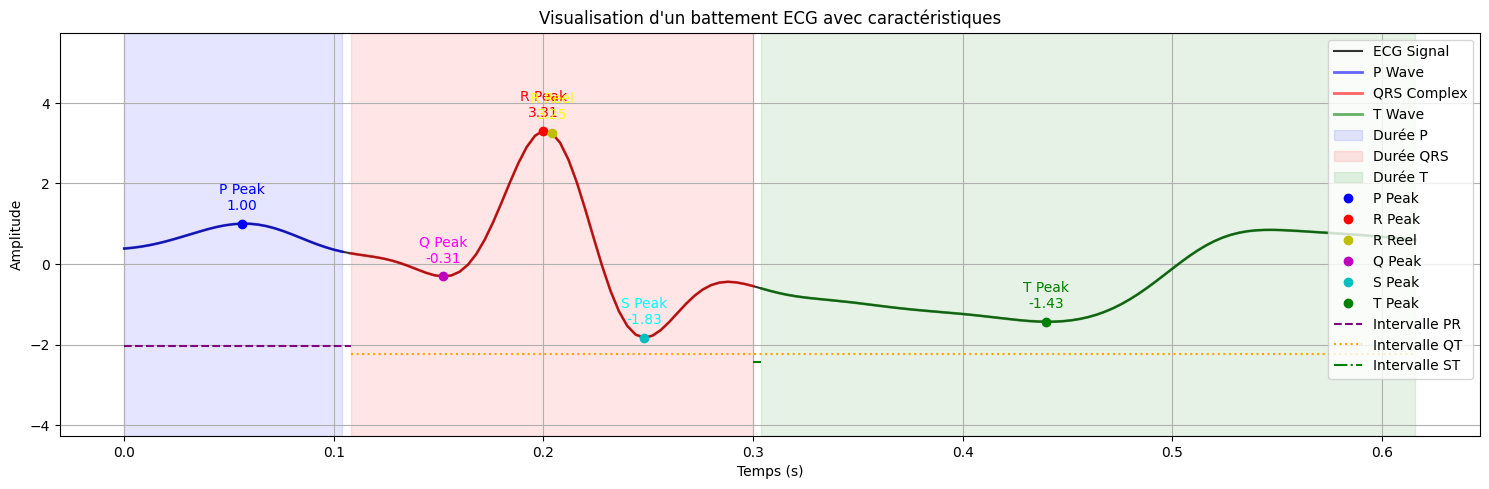

beat_features:  record_name                    221
beat_number                   1919
type                             N
R_index                     363235
start                       363215
end                         363337
qrs_start                   363215
qrs_end                     363262
p_start                        NaN
p_end                          NaN
t_start                   363275.0
t_end                     363337.0
Duree_P_ms                     0.0
Duree_QRS_ms                 192.0
Duree_T_ms                   252.0
Intervalle_PR_ms               0.0
Intervalle_QT_ms             488.0
Intervalle_ST_ms              52.0
P_index                          0
Amplitude_P                    0.0
Amplitude_R               3.838824
Intervalle_RR_ms             620.0
Q_index                     363223
Amplitude_Q               -0.59528
S_index                     363249
Amplitude_S              -0.779351
T_index                     363312
Amplitude_T               0.175447
T/R_

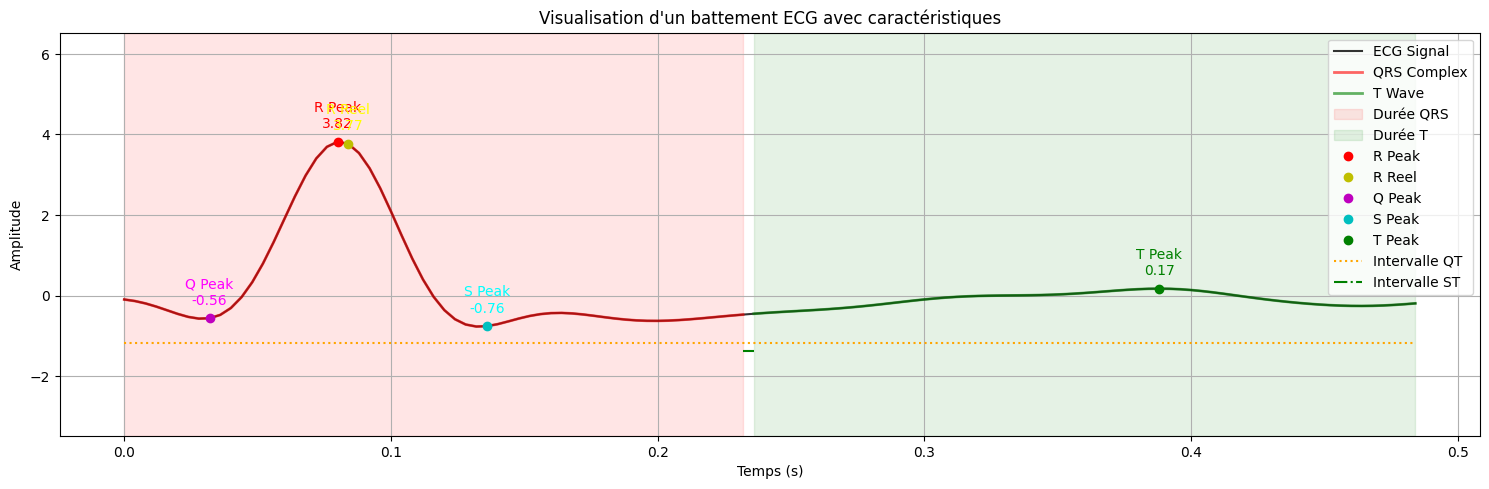

beat_features:  record_name              sele0110
beat_number                   258
type                            N
R_index                     70005
start                       69961
end                         70090
qrs_start                   69983
qrs_end                     70038
p_start                   69961.0
p_end                     69982.0
t_start                   70039.0
t_end                     70090.0
Duree_P_ms                   88.0
Duree_QRS_ms                224.0
Duree_T_ms                  208.0
Intervalle_PR_ms             88.0
Intervalle_QT_ms            428.0
Intervalle_ST_ms              4.0
P_index                     69972
Amplitude_P             -0.199473
Amplitude_R             -3.418958
Intervalle_RR_ms           1028.0
Q_index                     69994
Amplitude_Q             -0.238617
S_index                     70038
Amplitude_S              1.370387
T_index                     70067
Amplitude_T              5.958392
T/R_ratio                1.72780

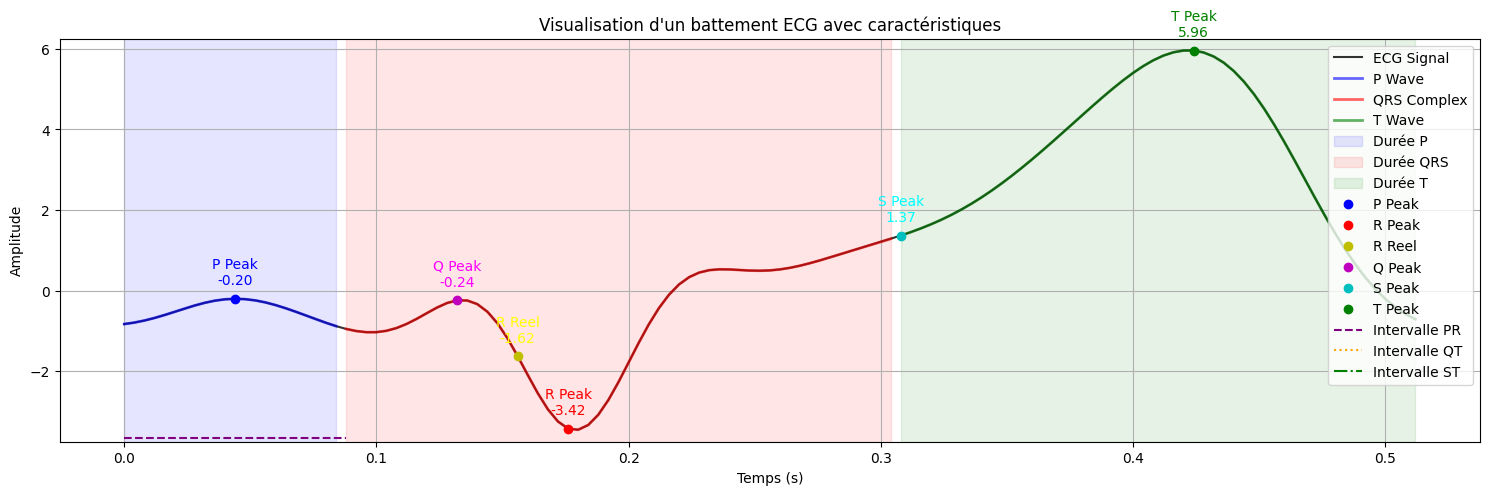

beat_features:  record_name               sel16786
beat_number                     82
type                             N
R_index                      20496
start                        20432
end                          20586
qrs_start                    20477
qrs_end                      20523
p_start                    20432.0
p_end                      20460.0
t_start                    20545.0
t_end                      20586.0
Duree_P_ms                   116.0
Duree_QRS_ms                 188.0
Duree_T_ms                   168.0
Intervalle_PR_ms             180.0
Intervalle_QT_ms             436.0
Intervalle_ST_ms              88.0
P_index                      20445
Amplitude_P                0.03202
Amplitude_R               5.204311
Intervalle_RR_ms            1056.0
Q_index                      20484
Amplitude_Q              -1.054774
S_index                      20510
Amplitude_S              -0.868705
T_index                      20569
Amplitude_T               1.701827
T/R_

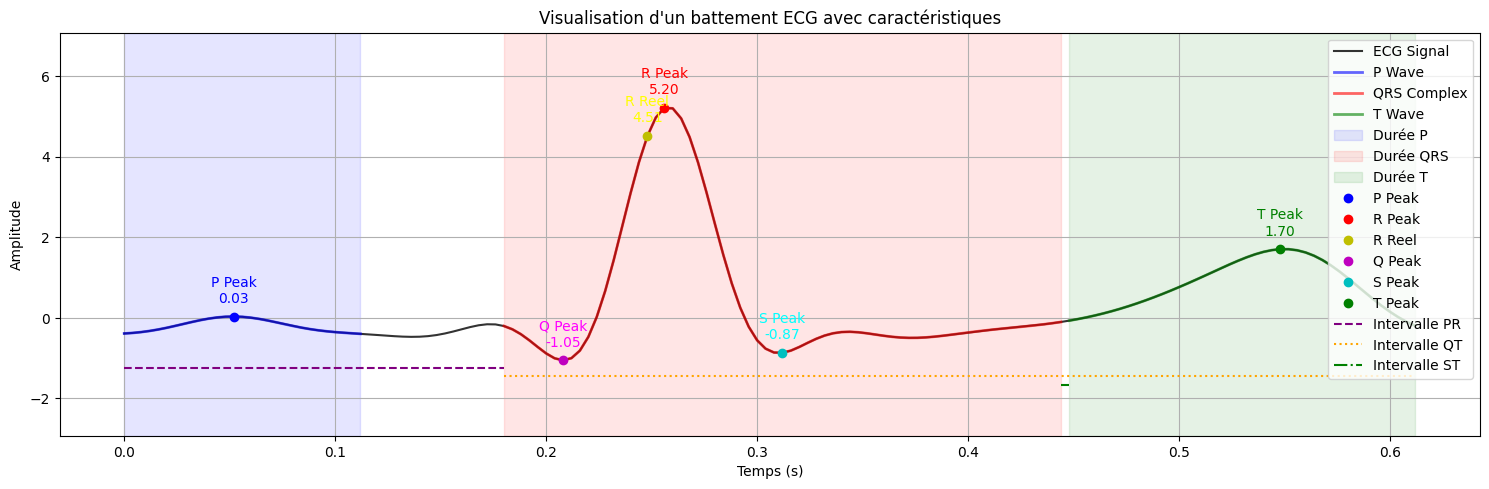

In [29]:


import random
for i in range(2):
    index = random.randint(0, len(df)-1)
    record_name = df.iloc[index]["record_name"]
    beat_number = df.iloc[index]["beat_number"]
    display_beat(df,record_name,beat_number)



import random
for i in range(2):
    index = random.randint(0, len(df2)-1)
    record_name = df2.iloc[index]["record_name"]
    beat_number = df2.iloc[index]["beat_number"]
    display_beat(df2,record_name,beat_number)

